# ELEC1103 - Basic Audio and Image with Python

### Written by Craig Jin

We explore working with audio and images using python.

In [1]:
# Import functions and libraries
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import threading,time, queue, pyaudio
from threading import Lock
import skimage
%matplotlib inline

ModuleNotFoundError: No module named 'pyaudio'

## Part 1: Sine wave

We will create a 1 Hz sine wave.


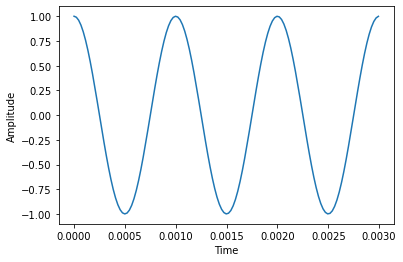

In [10]:
fs = 44100
fq = 1000 
tSamp = np.arange(np.ceil(0.5*44100))/fs
sig = np.cos(2 * np.pi * fq * tSamp)
threePd = int(np.ceil(3 * 44.1))
plt.plot(tSamp[0:threePd],sig[0:threePd])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()




### Playing and Recording the Sound
Now, we will play the sound of the chirp on our computer speaker and simultaneously record using the microphone. 

* On Apple computers it is recommended that you turn off the ambient noise reduction by going to system-preferences, selecting sound, choose the input tab and make sure that the "Use ambient noise reduction" box is unchecked. In some windows system there's ambient noise reduction as well. Make sure it is also turned off. 

* Your laptop most likely has two speakers. It is best if we work only with one. Go to the operating system's sound settings and change the stereo settings such that the speaker that is closest to the microphone is active. Your result will be much better that way. 
		
* Make sure your output volume is at 70-80% and that the laptop's microphone is on, again to avoid non-linear distorsions. 

* We will record 12 seconds just to make sure we capture the entire sequence. 

The code below defines some functions to use with pyaudio -- a multi-platform audio python interface. 

In [33]:
def play_audio( Q, p, fs , dev=None):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = queue.Queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data == "EOT" :
            break
        try:
            ostream.write( data.astype(np.float32).tostring() )
        except:
            break
            
def record_audio( queue, p, fs, dev=None,chunk=1024,lock=None):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = queue.Queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 3, 1) #
    # p.terminate() # terminate pyAudio
    
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is destroyed, stops
            with lock if lock is not None else 1:
                data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.frombuffer( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def xciever(sig, fs):
    # function takes a signal and a sampling frequency
    # it then plays and records at the same time. The function returns
    # the recorded sound.

    rcv = [];

    # create an input output FIFO queues
    Qin = queue.Queue()
    Qout = queue.Queue()

    #lock for controlling access to shared resources
    lock = Lock()
    
    # create a pyaudio object
    p = pyaudio.PyAudio()

    # initialize a recording thread.
    t_rec = threading.Thread(target = record_audio,   args = (Qin, p, fs ), kwargs={'lock': lock})
    t_play_audio = threading.Thread(target = play_audio,  args = (Qout, p, fs  ))

    # start the recording and playing threads
    t_rec.start()
    t_play_audio.start()

    Qout.put( sig );
    Qout.put( "EOT" );

    # pause for RECORD_SECS seconds
    RECORD_SECS = len(sig)/fs + 2.0
    time.sleep( RECORD_SECS )

    # terminate pyAudio
    with lock:
        p.terminate()
        
    # append to output
    while ( not Qin.empty()) :
        data = Qin.get()
        rcv = np.append( rcv, data )

    return rcv

def record_audio_timed(fs, recSec):
    # function takes a signal and a sampling frequency
    # it then records audio for the specified time. The function returns
    # the recorded sound.

    rcv = [];

    # create an input FIFO queues
    Qin = queue.Queue()

    #lock for controlling access to shared resources
    lock = Lock()
    
    # create a pyaudio object
    p = pyaudio.PyAudio()

    # initialize a recording thread.
    t_rec = threading.Thread(target = record_audio,   args = (Qin, p, fs ), kwargs={'lock': lock})

    # start the recording and playing threads
    t_rec.start()

    # pause for RECORD_SECS seconds
    time.sleep( recSec )

    # terminate pyAudio
    with lock:
        p.terminate()
        
    # append to output
    while ( not Qin.empty()) :
        data = Qin.get()
        rcv = np.append( rcv, data )
        
    return rcv

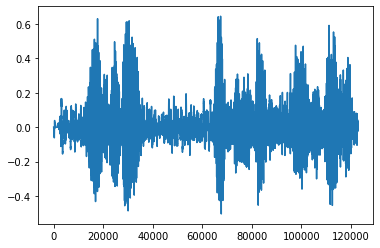

In [34]:
## Record Audio

recSig = record_audio_timed(44100, 3.0)
    
plt.plot(recSig)

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


### Read and Showing Images
Now, we will demonstrate some basic image tools with python.


In [14]:
img=mpimg.imread('stinkbug.png')
print (img)

[[[0.40784314 0.40784314 0.40784314]
  [0.40784314 0.40784314 0.40784314]
  [0.40784314 0.40784314 0.40784314]
  ...
  [0.42745098 0.42745098 0.42745098]
  [0.42745098 0.42745098 0.42745098]
  [0.42745098 0.42745098 0.42745098]]

 [[0.4117647  0.4117647  0.4117647 ]
  [0.4117647  0.4117647  0.4117647 ]
  [0.4117647  0.4117647  0.4117647 ]
  ...
  [0.42745098 0.42745098 0.42745098]
  [0.42745098 0.42745098 0.42745098]
  [0.42745098 0.42745098 0.42745098]]

 [[0.41960785 0.41960785 0.41960785]
  [0.41568628 0.41568628 0.41568628]
  [0.41568628 0.41568628 0.41568628]
  ...
  [0.43137255 0.43137255 0.43137255]
  [0.43137255 0.43137255 0.43137255]
  [0.43137255 0.43137255 0.43137255]]

 ...

 [[0.4392157  0.4392157  0.4392157 ]
  [0.43529412 0.43529412 0.43529412]
  [0.43137255 0.43137255 0.43137255]
  ...
  [0.45490196 0.45490196 0.45490196]
  [0.4509804  0.4509804  0.4509804 ]
  [0.4509804  0.4509804  0.4509804 ]]

 [[0.44313726 0.44313726 0.44313726]
  [0.44313726 0.44313726 0.44313726]


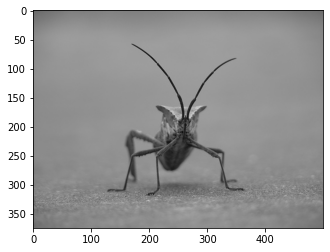

In [27]:
plt.imshow(img)
plt.show()

In [28]:
from skimage import io, img_as_float, img_as_uint


TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [29]:
img = img_as_float(io.imread('stinkbug.png'))
print (img)

NameError: name 'img_as_float' is not defined

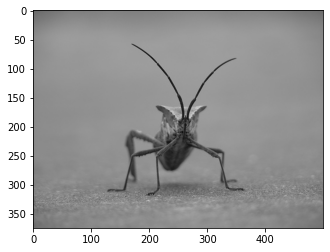

In [30]:
plt.imshow(img)
plt.show()

In [31]:
#io.use_plugin('freeimage')
io.imsave('test.png',img_as_uint(img))

NameError: name 'io' is not defined

In [32]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
myImage = cv.imread('lena512color.tiff')
print (type(myImage))
plt.imshow(myImage)

ModuleNotFoundError: No module named 'cv2'